In [52]:
import sys, os
from cProfile import label

import numpy as np
import matplotlib.pyplot as plt
import warnings
import tools

In [53]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [54]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
modeApi = lumapi.MODE()

In [55]:
#units
nm = 1e-9
um = 1e-6

<h1>Dimensões, materiais e outas especificações do guia (PDK)</h1>

In [56]:
sub_material = 'SiO2 (Glass) - Palik'

gap = 200*nm
x_span_core = 500*nm
x_core = (x_span_core+gap)/2
y_core = 0.0*um
y_span_core = 0.220*um
z_core = 0.0*um
z_core_span = 1.0*um
core_material = 'Si (Silicon) - Palik'

Objetos do dispositivo

In [57]:
#waveguide
modeApi.addrect()
modeApi.set('name', 'core_1')
modeApi.set('x', -x_core)
modeApi.set('x span', x_span_core)
modeApi.set('y', y_core)
modeApi.set('y span', y_span_core)
modeApi.set('z', z_core)
modeApi.set('z span', z_core_span)
modeApi.set('material', core_material)

modeApi.copy()
modeApi.set('name', 'core_2')
modeApi.set('x', x_core)

Dimensões e características do solver

In [58]:
fde_solve_material = sub_material
x_fde = 0.0
x_span_fde = 4*um
y_fde = 0.0
y_span_fde = 4*um
z_fde = 0.0
z_span_fde = 0*um
mesh_cells = 100
wavelength = 1550*nm

startWvg = 1550*nm
stopWvg = 1550*nm
modes = 4
mesh_multiplier = 4

In [59]:
#solver
modeApi.addfde()
modeApi.set('Solver type', '2D Z normal')
modeApi.set('background material', fde_solve_material)

modeApi.set('x', x_fde)
modeApi.set('x span', x_span_fde)
modeApi.set('y', y_fde)
modeApi.set('y span', y_span_fde)
modeApi.set('z', z_fde)

modeApi.set('define x mesh by', 'number of mesh cells')
modeApi.set('define y mesh by', 'number of mesh cells')
modeApi.set('mesh cells x', mesh_cells)
modeApi.set('mesh cells y', mesh_cells)

modeApi.set('wavelength', wavelength)
modeApi.set('number of trial modes', modes)

modeApi.set('fit materials with multi-coefficient model', True)
modeApi.set('wavelength start', startWvg)
modeApi.set('wavelength stop', stopWvg)

modeApi.set('x min bc', 'PML')
modeApi.set('x max bc', 'PML')
modeApi.set('y min bc', 'PML')
modeApi.set('y max bc', 'PML')

#adding mesh
modeApi.addmesh()
modeApi.set('set mesh multiplier', True)
modeApi.set('x', x_fde)
modeApi.set('x span', 0.35*x_span_fde)
modeApi.set('x mesh multiplier', mesh_multiplier)
modeApi.set('y', y_fde)
modeApi.set('y span', 0.15*y_span_fde)
modeApi.set('y mesh multiplier', mesh_multiplier)
modeApi.set('z span', 0)

Determinação dos modos propagantes

In [60]:
nmbOfModes = int(modeApi.findmodes())

In [61]:
eField = np.squeeze(modeApi.getresult('FDE::data::mode1', 'Ex'))
x_efielf = modeApi.getresult('FDE::data::mode1', 'x')/um
y_efielf = modeApi.getresult('FDE::data::mode1', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_y'))

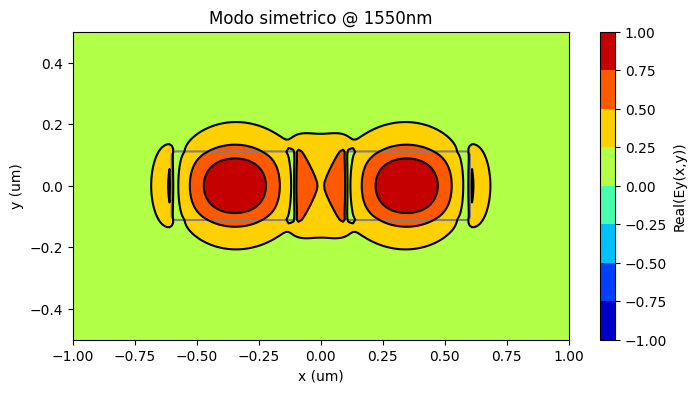

In [62]:
v = np.linspace(-1,1,9, endpoint = True)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x_efielf, y_efielf)
plt.contour(X,Y,np.rot90(rfIndex.real),0, colors='gray', origin='upper')
plt.contour(X,Y,np.rot90(eField.real),v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(X,Y, np.rot90(eField.real),v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
colorbar.set_ticks(v)
colorbar.set_label(r'Real(Ey(x,y))')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title('Modo simetrico @ 1550nm')
plt.xlim([-1,1])
plt.ylim([-0.5,0.5])

plt.savefig('symmetric_mode.png')

Modo assímetrico

In [63]:
eField = np.squeeze(modeApi.getresult('FDE::data::mode2', 'Ex'))
x_efielf = modeApi.getresult('FDE::data::mode2', 'x')/um
y_efielf = modeApi.getresult('FDE::data::mode2', 'y')/um

rfIndex = np.squeeze(modeApi.getdata('FDE::data::material', 'index_y'))

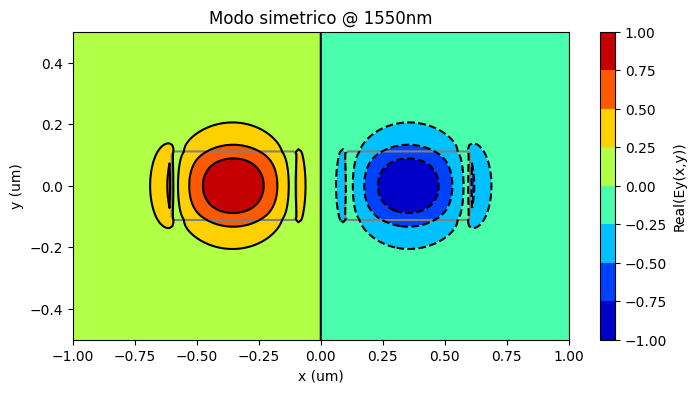

In [64]:
v = np.linspace(-1,1,9, endpoint = True)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
X,Y = np.meshgrid(x_efielf, y_efielf)
plt.contour(X,Y,np.rot90(rfIndex.real),0, colors='gray', origin='upper')
plt.contour(X,Y,np.rot90(eField.real),v, colors='k', vmin=-1, vmax=1)
im = plt.contourf(X,Y, np.rot90(eField.real),v, cmap=plt.cm.jet, vmin=-1, vmax=1)

colorbar = plt.colorbar(im)
colorbar.set_ticks(v)
colorbar.set_label(r'Real(Ey(x,y))')
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.title('Modo simetrico @ 1550nm')
plt.xlim([-1,1])
plt.ylim([-0.5,0.5])

plt.savefig('asymmetric_mode.png')

<h1>Acoplamento de potência em função do comprimento do dispositivo</h1>

In [65]:
n1 = modeApi.getresult('FDE::data::mode1', 'neff')
n2 = modeApi.getresult('FDE::data::mode2', 'neff')
L_x = wavelength/(2*np.abs(n1.real - n2.real))

In [72]:
#FSR/B = 30 makes it looks a bit more ideal
#14, 5 e 12
ng = 4.19088
my_dict = tools.ringData(10,2,ng,20e-9)
kappa1sqrd = my_dict['K'][0]
kappa2sqrd = my_dict['K'][2]
print(my_dict['K'])

[np.float64(0.31415926535897937), np.float64(0.31415926535897937), np.float64(0.04934802200544681)] a


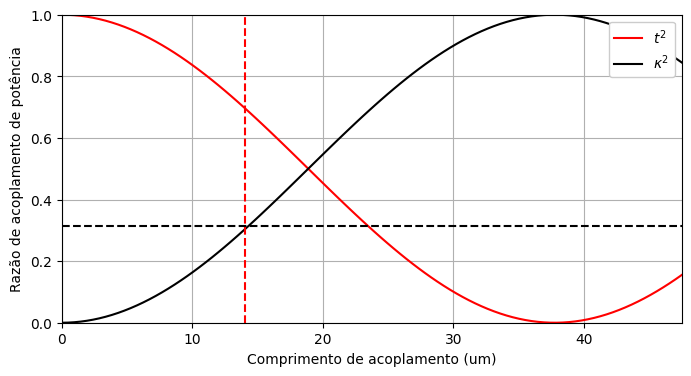

In [75]:
#kappa 1
lenDC = np.linspace(0, 47.5*um,100) #47.5 is the greatest value that the pdk device can have
tSqr = np.squeeze((np.cos(np.pi/2*lenDC/L_x))**2)
kappaSqr = np.squeeze((np.sin(np.pi/2*lenDC/L_x))**2)

fig = plt.figure(figsize = (8,4))
plt.plot(lenDC/um, tSqr, 'r', label=r'$t^2$')
plt.plot(lenDC/um, kappaSqr, 'k', label=r'$\kappa^2$')
plt.hlines(kappa1sqrd,xmin=0,xmax=47.5, color='black',linestyles='dashed')
plt.vlines(14,ymin=0,ymax=1, color='r',linestyles='dashed')
plt.xlabel('Comprimento de acoplamento (um)')
plt.ylabel('Razão de acoplamento de potência')
plt.xlim([0, 47.5])
plt.ylim([0, 1])
plt.grid()
plt.legend(loc=1,framealpha=1)
plt.savefig('kappa_vs_LC.png')

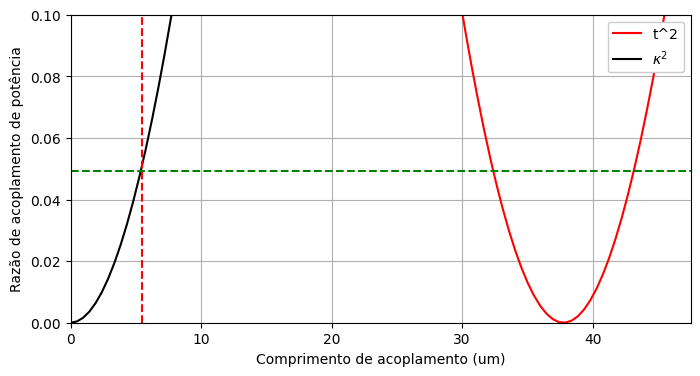

In [76]:
#kappa 2
lenDC = np.linspace(0, 47.5*um,100) #47.5 is the greatest value that the pdk device can have
tSqr = np.squeeze((np.cos(np.pi/2*lenDC/L_x))**2)
kappaSqr = np.squeeze((np.sin(np.pi/2*lenDC/L_x))**2)

fig = plt.figure(figsize = (8,4))
plt.plot(lenDC/um, tSqr, 'r', label=r'$t^2$')
plt.plot(lenDC/um, kappaSqr, 'k', label=r'$\kappa^2$')
plt.vlines(5.5,ymin=0,ymax=1, color='r',linestyles='dashed')
plt.hlines(kappa2sqrd,xmin=0,xmax=47.5, color='green',linestyles='dashed')
plt.xlabel('Comprimento de acoplamento (um)')
plt.ylabel('Razão de acoplamento de potência')
plt.xlim([0, 47.5])
plt.ylim([0, 0.1])
plt.grid()
plt.legend(loc=1,framealpha=1)
plt.savefig('kappa_vs_LC2.png')